# Data Wrangling: WeRateDogs Twitter Data

In [2]:
# Importing required libraries

import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

## Gathering

### Twitter Archive

In [3]:
# loading twitter archive file into pandas df

archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Image Predictions

In [4]:
# Downloading image predictions file programmatically 

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
file_name = url.split('/')[-1]
if not os.path.isfile(file_name):
    with open(file_name, mode='wb') as file:
        file.write(response.content)
file_name

'image-predictions.tsv'

In [5]:
# loading image predictions file into pandas df.

image_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Twitter API & JSON

In [6]:
# API Quering

consumer_key = '*********************************'
consumer_secret = '6dt5PKQBtZNDQcR5WZT2gKOhiQgtUd3xf6AX2mqTnseAqj1HbI'
access_token = '1132165985639657472-pjGBDwMx1ftqMlV1Gwz9odommtjJfu'
access_secret = 'MGNjmdyVsDO2aEWbkaQkv3UAiP4tXlwwM25Crj5jNAK96'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [7]:
# Experimenting to extract one tweet's id information

exp_tweet = api.get_status(archive_df.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
content

{'created_at': 'Wed Jun 29 01:23:16 +0000 2016',
 'id': 747963614829678593,
 'id_str': '747963614829678593',
 'full_text': 'PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q',
 'truncated': False,
 'display_text_range': [0, 70],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 747963600220917761,
    'id_str': '747963600220917761',
    'indices': [71, 94],
    'media_url': 'http://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg',
    'url': 'https://t.co/ZPfeRtOX0Q',
    'display_url': 'pic.twitter.com/ZPfeRtOX0Q',
    'expanded_url': 'https://twitter.com/dog_rates/status/747963614829678593/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 937, 'h': 632, 'resize': 'fit'},
     'small': {'w': 680, 'h': 459, 'resize': 'fit'},
     'large': {'w': 937, 'h': 632, '

In [8]:
# Creating a file for the tweets' text data

errors = []
if not os.path.isfile('tweet_json.txt'):
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in archive_df['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

In [9]:
# Read text file line by line to create dataframe

tweets_list = []
with open ('tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweets_list.append(tweet)
api_df = pd.DataFrame(tweets_list)
api_df = api_df[['id_str', 'retweet_count', 'favorite_count']]

In [10]:
api_df.head()

,id_str,retweet_count,favorite_count
0,892420643555336193,7388,35100
1,892177421306343426,5504,30383
2,891815181378084864,3636,22846
3,891689557279858688,7556,38327
4,891327558926688256,8148,36643


## Assessing

### Twitter Archive
- Visual Assessment

In [11]:
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


- Programmatic Assessment

In [12]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
archive_df.shape

(2356, 17)

In [15]:
sum(archive_df.duplicated())

0

In [16]:
len(archive_df[archive_df.retweeted_status_id.isnull() == False])

181

In [17]:
archive_df['rating_denominator'].value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [18]:
archive_df['rating_numerator'].value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [19]:
archive_df['name'].value_counts()

None           745
a               55
Charlie         12
Lucy            11
Oliver          11
Cooper          11
Penny           10
Lola            10
Tucker          10
Bo               9
Winston          9
the              8
Sadie            8
Toby             7
Bailey           7
Buddy            7
an               7
Daisy            7
Scout            6
Jax              6
Dave             6
Rusty            6
Bella            6
Jack             6
Oscar            6
Koda             6
Leo              6
Stanley          6
Milo             6
Finn             5
              ... 
Evy              1
Clarkus          1
Rilo             1
Sephie           1
Trip             1
Sid              1
Kanu             1
Oddie            1
Zooey            1
Bones            1
Jay              1
Snoopy           1
Shikha           1
Dale             1
Alfy             1
Banjo            1
Kendall          1
Charl            1
Linus            1
Eriq             1
Dobby            1
infuriating 

In [20]:
archive_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

### Observations

### Quality Aspects
- 'name' column has alot of unmeaningful and invalid values (a, an, etc... ).
- 'timestamp' and 'retweeted_status_timestamp' columns are str instead of datetime.
- 'source' column's values are formatted as html tags "< a > href=url < / a >".
- Retweets and replies on the original tweets are presented in the data.
- columns that include ID variables are sometimes integers or floats instead of strings.
- 'rating_denominator' column has values more or less than 10.
- 'rating_numerator' column should be float type so it can accounting for decimals correctly. 


### Tidiness Aspects
- Many columns for the same measurement unit ('doggo', 'floofer', 'pupper', 'puppo'), i.e. Dog stage


### Image Predictions
- Visual Assessment

In [21]:
image_predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [22]:
image_predictions_df.shape

(2075, 12)

- Programmatic Assessment

In [23]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
image_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [25]:
sum(image_predictions_df.duplicated())

0

In [26]:
image_predictions_df['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [27]:
image_predictions_df['jpg_url'].sample(20)

308     https://pbs.twimg.com/media/CVHG6_AWwAEJf_u.jpg
948     https://pbs.twimg.com/media/CcgF5ovW8AACrEU.jpg
230     https://pbs.twimg.com/media/CU3FbQgVAAACdCQ.jpg
1616    https://pbs.twimg.com/media/CyI3zXgWEAACQfB.jpg
1803    https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg
445     https://pbs.twimg.com/media/CVzTUGrW4AAirJH.jpg
547     https://pbs.twimg.com/media/CWZdaGxXAAAjGjb.jpg
1344    https://pbs.twimg.com/media/Cojc_Q0WcAAqi_K.jpg
246     https://pbs.twimg.com/media/CU4AwqQWUAAEgE2.jpg
190     https://pbs.twimg.com/media/CUopnHPVEAAcL2o.jpg
1779    https://pbs.twimg.com/media/C38aQYgXAAMY2Wh.jpg
1146    https://pbs.twimg.com/media/CiOEnI6WgAAmq4E.jpg
1369    https://pbs.twimg.com/media/CpMVxoRXgAAh350.jpg
1132    https://pbs.twimg.com/media/ChvAQuMWMAAVaKD.jpg
576     https://pbs.twimg.com/media/CWskEqnWUAAQZW_.jpg
753     https://pbs.twimg.com/media/CYznjAcUEAQ5Zq7.jpg
1630    https://pbs.twimg.com/media/Cy2qiTxXcAAtQBH.jpg
848     https://pbs.twimg.com/media/Caa407jWwAAJ

### Observations
### Quality Aspects
- Some columns name are unmeaningful and non-descriptive.
- Missing photos for some IDs as the total numberof records (2075 instead of 2356)
- Inconsistent capitalization for some columns values (p1, p2, p3)

### Tidiness Aspects
- Many columns for the same measurement unit ('p1', 'p2', 'p3') and they all present breed predictions

### API 
- Visual Assessment

In [28]:
api_df

,id_str,retweet_count,favorite_count
0,892420643555336193,7388,35100
1,892177421306343426,5504,30383
2,891815181378084864,3636,22846
3,891689557279858688,7556,38327
4,891327558926688256,8148,36643
5,891087950875897856,2732,18482
6,890971913173991426,1767,10745
7,890729181411237888,16537,59097
8,890609185150312448,3783,25427
9,890240255349198849,6412,29015


- Programmatic Assessment

In [29]:
api_df.shape

(2331, 3)

In [30]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id_str            2331 non-null object
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


In [31]:
api_df.describe()

,retweet_count,favorite_count
count,2331.000000,2331.000000
mean,2597.046332,7328.510082
std,4393.173965,11382.517976
min,1.000000,0.000000
25%,527.500000,1271.500000
50%,1212.000000,3183.000000
75%,3009.500000,8957.500000
max,74547.000000,150931.000000


In [32]:
sum(api_df.duplicated())

0

### Observations

### Quality Aspects
- Missing retweet or favorite counts for some IDs as the total number of records (2331 instead of 2356)

### Tidiness Aspects
- Not observitional unit to have its own table 

## Cleaning
### First let's make a copy of each piece of data before any cleaning occurs

In [33]:
cleaned_archive_df = archive_df.copy()
cleaned_image_predictions_df = image_predictions_df.copy()
cleaned_api_df = api_df.copy()

## Twitter Archive

### Define 
Convert timestamp columns to datetime

### Code

In [34]:
cleaned_archive_df.timestamp = pd.to_datetime(cleaned_archive_df.timestamp)
cleaned_archive_df['retweeted_status_timestamp'] = pd.to_datetime(cleaned_archive_df['retweeted_status_timestamp'])

### Test

In [35]:
cleaned_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Define
Extract tweet source from source column 

### Code

In [36]:
cleaned_archive_df.source.unique()

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], dtype=object)

In [37]:
def fix_source(x):
    i= x.find('>') + 1
    j =x[i:].find('<')
    return x[i:][:j]

In [38]:

cleaned_archive_df.source = cleaned_archive_df.source.apply(lambda x: fix_source(x))

### Test

In [39]:
cleaned_archive_df.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

### Define
Remove retweets and replies

### Code

In [40]:

cleaned_archive_df = cleaned_archive_df.query('in_reply_to_status_id == "NaN" &\
                                                     in_reply_to_user_id == "NaN" &\
                                                    retweeted_status_id == "NaN" &\
                                                    retweeted_status_user_id == "NaN"')

cols = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id', 'retweeted_status_timestamp']
cleaned_archive_df.drop(columns = cols, axis=1, inplace=True)

### Test

In [41]:
cleaned_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 213.0+ KB


### Define
Remove values that more or less than 10 in 'rating_denominator' column

### Code

In [42]:
cleaned_archive_df = cleaned_archive_df[cleaned_archive_df['rating_denominator'] == 10]

### Test

In [43]:
cleaned_archive_df['rating_denominator'].describe()

count    2080.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: rating_denominator, dtype: float64

### Define
Convert 'rating_numerator' column to float type so it can accounting for decimals correctly.

### Code

In [44]:
cleaned_archive_df['rating_numerator'] = cleaned_archive_df['rating_numerator'].astype(float)

### Test

In [45]:
cleaned_archive_df['rating_numerator'].dtype

dtype('float64')

In [46]:
cleaned_archive_df.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1489,692905862751522816,2016-01-29 03:03:25,Twitter for iPhone,This is Wally. He's being abducted by aliens. ...,https://twitter.com/dog_rates/status/692905862...,10.0,10,Wally,None,None,pupper,None
1876,675111688094527488,2015-12-11 00:35:44,Twitter for iPhone,Say hello to Oliver. He thought what was insid...,https://twitter.com/dog_rates/status/675111688...,8.0,10,Oliver,None,None,None,None
2129,670290420111441920,2015-11-27 17:17:44,Twitter for iPhone,This is Sandra. She's going skydiving. Nice ad...,https://twitter.com/dog_rates/status/670290420...,11.0,10,Sandra,None,None,None,None
806,772102971039580160,2016-09-03 16:04:27,Twitter for iPhone,This is Penny. She's an OU cheerleader. About ...,https://twitter.com/dog_rates/status/772102971...,11.0,10,Penny,None,None,None,None
288,838476387338051585,2017-03-05 19:48:43,Twitter for iPhone,This is Stanley. Somehow he heard you tell him...,https://twitter.com/dog_rates/status/838476387...,13.0,10,Stanley,None,None,None,None


### Define
Create new column 'dog_stage' instead of the four columns 
'doggo', 'floofer', 'pupper' and 'puppo'

### Code

In [47]:
def dog_stage(row):
    stage = []
    if row['doggo'] == 'doggo':
        stage.append('doggo')
    if row['floofer'] == 'floofer':
        stage.append('floofer')
    if row['pupper'] == 'pupper':
        stage.append('pupper')
    if row['puppo'] == 'puppo':
        stage.append('puppo')
    
    if not stage:
        return "None"
    else:
        return ','.join(stage)
    
cleaned_archive_df['dog_stage'] = cleaned_archive_df.apply(lambda row: dog_stage(row), axis=1)

In [48]:
cleaned_archive_df.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)

### Test

In [49]:
cleaned_archive_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None


In [50]:
cleaned_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2080 non-null int64
timestamp             2080 non-null datetime64[ns]
source                2080 non-null object
text                  2080 non-null object
expanded_urls         2077 non-null object
rating_numerator      2080 non-null float64
rating_denominator    2080 non-null int64
name                  2080 non-null object
dog_stage             2080 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 162.5+ KB


### Define
Replace 'None' with np.nan in 'name' column and remove any rows with invalid names.

### Code


In [51]:
cleaned_archive_df[cleaned_archive_df.name.str.islower()==True].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'my',
       'his', 'an', 'actually', 'just', 'getting', 'mad', 'unacceptable',
       'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life',
       'light', 'space'], dtype=object)

In [52]:
invalid_names = ['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space', 'None']
cleaned_archive_df.name.replace(invalid_names, np.nan, inplace=True)

### Test

In [53]:
cleaned_archive_df.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', nan, 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Canela', 'Maya', 'Mingus',
       'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl', 'Lola',
       'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty', 'Gus',
       'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot', 'Louis',
       'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven', 'Beau',
       'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante', 'Nelly',
       'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash', 'Jed',
       'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford', 'Dewey',
       'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha', 'Lili',
       'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jersey', 'Hobbes',


In [54]:
cleaned_archive_df.name.value_counts()

Charlie      11
Lucy         11
Cooper       10
Oliver       10
Tucker        9
Penny         9
Lola          8
Sadie         8
Winston       8
Toby          7
Daisy         7
Bo            6
Stanley       6
Koda          6
Jax           6
Bailey        6
Oscar         6
Bella         6
Louis         5
Buddy         5
Leo           5
Chester       5
Scout         5
Milo          5
Dave          5
Bentley       5
Rusty         5
Gus           4
Chip          4
Jerry         4
             ..
Pancake       1
Liam          1
Hall          1
Fynn          1
Tove          1
Derby         1
Acro          1
Nida          1
Pinot         1
Hercules      1
Sobe          1
Molly         1
Brady         1
Kathmandu     1
Clyde         1
Mingus        1
Stephan       1
Skye          1
Emanuel       1
Timmy         1
Ralphus       1
Baloo         1
Dook          1
Flash         1
Sailor        1
Chef          1
Tuck          1
Jangle        1
Ralphson      1
Timison       1
Name: name, Length: 927,

### Define
Remove rows with NaNs for 'expanded_urls' column i.e. missing photos

### Code

In [55]:
cleaned_archive_df.loc[cleaned_archive_df['expanded_urls'].isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
375,828361771580813312,2017-02-05 21:56:51,Twitter Web Client,Beebop and Doobert should start a band 12/10 w...,NaN,12.0,10,NaN,None
707,785515384317313025,2016-10-10 16:20:36,Twitter for iPhone,"Today, 10/10, should be National Dog Rates Day",NaN,10.0,10,NaN,None
1445,696518437233913856,2016-02-08 02:18:30,Twitter for iPhone,Oh my god 10/10 for every little hot dog pupper,NaN,10.0,10,NaN,pupper


In [56]:
cleaned_archive_df = cleaned_archive_df.drop([375, 707, 1445])

### Test

In [57]:
cleaned_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2077 non-null int64
timestamp             2077 non-null datetime64[ns]
source                2077 non-null object
text                  2077 non-null object
expanded_urls         2077 non-null object
rating_numerator      2077 non-null float64
rating_denominator    2077 non-null int64
name                  1387 non-null object
dog_stage             2077 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 162.3+ KB


In [58]:
cleaned_archive_df.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
975,750041628174217216,2016-07-04 19:00:33,TweetDeck,This is Beau. He's trying to keep his daddy fr...,https://twitter.com/dog_rates/status/750041628...,13.0,10,Beau,None
443,819347104292290561,2017-01-12 00:55:47,Twitter for iPhone,Say hello to Anna and Elsa. They fall asleep i...,https://twitter.com/dog_rates/status/819347104...,12.0,10,Anna,None
1393,700029284593901568,2016-02-17 18:49:22,Twitter for iPhone,This is Coops. His ship is taking on water. So...,https://twitter.com/dog_rates/status/700029284...,10.0,10,Coops,None
732,781524693396357120,2016-09-29 16:03:01,Twitter for iPhone,Idk why this keeps happening. We only rate dog...,https://twitter.com/dog_rates/status/781524693...,12.0,10,NaN,None
1562,688211956440801280,2016-01-16 04:11:31,Twitter for iPhone,This is Derby. He's a superstar. 13/10 (vid by...,https://twitter.com/dog_rates/status/688211956...,13.0,10,Derby,None
2202,668643542311546881,2015-11-23 04:13:37,Twitter for iPhone,Fascinating dog here. Loves beach. Oddly long ...,https://twitter.com/dog_rates/status/668643542...,3.0,10,NaN,None
1057,742150209887731712,2016-06-13 00:22:53,Twitter for iPhone,This is Edmund. He sends stellar selfies. Cute...,https://twitter.com/dog_rates/status/742150209...,8.0,10,Edmund,pupper
723,782969140009107456,2016-10-03 15:42:44,Twitter for iPhone,This is Cali. She arrived preassembled. Conven...,https://twitter.com/dog_rates/status/782969140...,12.0,10,Cali,None
11,889880896479866881,2017-07-25 16:11:53,Twitter for iPhone,This is Bruno. He is a service shark. Only get...,https://twitter.com/dog_rates/status/889880896...,13.0,10,Bruno,None
1092,737322739594330112,2016-05-30 16:40:14,Twitter for iPhone,Say hello to Lily. She's not injured or anythi...,https://twitter.com/dog_rates/status/737322739...,9.0,10,Lily,None


## Image Predictions

### Define
Capitalize the first letter of names of 'p1', 'p2', 'p3' columns

### Code

In [59]:
cleaned_image_predictions_df.p1= cleaned_image_predictions_df.p1.str.capitalize()
cleaned_image_predictions_df.p2= cleaned_image_predictions_df.p2.str.capitalize()
cleaned_image_predictions_df.p3= cleaned_image_predictions_df.p3.str.capitalize()

### Test

In [60]:
cleaned_image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Define
Create breed and confidence columns with highest confidence predictions and drop other columns

### Code

In [61]:
breed = []
confidence = []
for index, row in cleaned_image_predictions_df.iterrows():
    if row['p1_dog'] and row['p1_conf'] == max([row['p1_conf'], row['p2_conf'], row['p3_conf']]):
        breed.append(row['p1'])
        confidence.append(row['p1_conf'])
    elif row['p2_dog'] and row['p2_conf'] == max([row['p1_conf'], row['p2_conf'], row['p3_conf']]):
        breed.append(row['p2'])
        confidence.append(row['p2_conf'])
    elif row['p3_dog'] and row['p3_conf'] == max([row['p1_conf'], row['p2_conf'], row['p3_conf']]):
        breed.append(row['p3'])
        confidence.append(row['p3_conf'])
    else:
        breed.append(np.nan)
        confidence.append(np.nan)
        
cleaned_image_predictions_df['breed'] = breed
cleaned_image_predictions_df['confidence'] = confidence

cleaned_image_predictions_df = cleaned_image_predictions_df[['tweet_id', 'jpg_url', 'breed', 'confidence']]

### Test

In [62]:
cleaned_image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id      2075 non-null int64
jpg_url       2075 non-null object
breed         1532 non-null object
confidence    1532 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 64.9+ KB


In [63]:
cleaned_image_predictions_df.head()

,tweet_id,jpg_url,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature_pinscher,0.560311


## API

### Define
Rename 'id_str' column to 'tweet_id' so we can merge the data into database

### Code

In [64]:
cleaned_api_df.columns = ['tweet_id', 'retweet_count', 'favorite_count']

### Test

In [65]:
cleaned_api_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7388,35100
1,892177421306343426,5504,30383
2,891815181378084864,3636,22846
3,891689557279858688,7556,38327
4,891327558926688256,8148,36643


### Define
Convert 'tweet_id' columns to str for the three data sets

### Code

In [66]:
cleaned_archive_df['tweet_id'] = cleaned_archive_df['tweet_id'].astype('str')
cleaned_image_predictions_df['tweet_id'] = cleaned_image_predictions_df['tweet_id'].astype('str')
cleaned_api_df['tweet_id'] = cleaned_api_df['tweet_id'].astype('str')

### Test

In [67]:
cleaned_archive_df['tweet_id'].dtype
cleaned_image_predictions_df['tweet_id'].dtype
cleaned_api_df['tweet_id'].dtype

dtype('O')

In [68]:
cleaned_api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null object
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


In [69]:
cleaned_image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id      2075 non-null object
jpg_url       2075 non-null object
breed         1532 non-null object
confidence    1532 non-null float64
dtypes: float64(1), object(3)
memory usage: 64.9+ KB


In [70]:
cleaned_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2077 non-null object
timestamp             2077 non-null datetime64[ns]
source                2077 non-null object
text                  2077 non-null object
expanded_urls         2077 non-null object
rating_numerator      2077 non-null float64
rating_denominator    2077 non-null int64
name                  1387 non-null object
dog_stage             2077 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 162.3+ KB


### Define
Merge Data inot database

### Code

In [71]:
df_merge = pd.merge(cleaned_archive_df, cleaned_image_predictions_df, on='tweet_id')
df_merge = pd.merge(df_merge, cleaned_api_df, on = 'tweet_id')

### Test

In [72]:
df_merge.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,breed,confidence,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,NaN,7388,35100
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,5504,30383
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,3636,22846
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,NaN,NaN,7556,38327
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset,0.555712,8148,36643


In [73]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1947 entries, 0 to 1946
Data columns (total 14 columns):
tweet_id              1947 non-null object
timestamp             1947 non-null datetime64[ns]
source                1947 non-null object
text                  1947 non-null object
expanded_urls         1947 non-null object
rating_numerator      1947 non-null float64
rating_denominator    1947 non-null int64
name                  1339 non-null object
dog_stage             1947 non-null object
jpg_url               1947 non-null object
breed                 1442 non-null object
confidence            1442 non-null float64
retweet_count         1947 non-null int64
favorite_count        1947 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 228.2+ KB


## Data Storing

In [74]:
df_merge.to_csv('twitter_archive_master.csv', index=False)

In [75]:
wrangling_df = pd.read_csv('twitter_archive_master.csv')

In [76]:
wrangling_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,breed,confidence,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,NaN,7388,35100
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,5504,30383
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,3636,22846
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,NaN,NaN,7556,38327
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset,0.555712,8148,36643


In [77]:
wrangling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 14 columns):
tweet_id              1947 non-null int64
timestamp             1947 non-null object
source                1947 non-null object
text                  1947 non-null object
expanded_urls         1947 non-null object
rating_numerator      1947 non-null float64
rating_denominator    1947 non-null int64
name                  1339 non-null object
dog_stage             1947 non-null object
jpg_url               1947 non-null object
breed                 1442 non-null object
confidence            1442 non-null float64
retweet_count         1947 non-null int64
favorite_count        1947 non-null int64
dtypes: float64(2), int64(4), object(8)
memory usage: 213.0+ KB


## Visualizations
- Relation between retweet count and favorite count

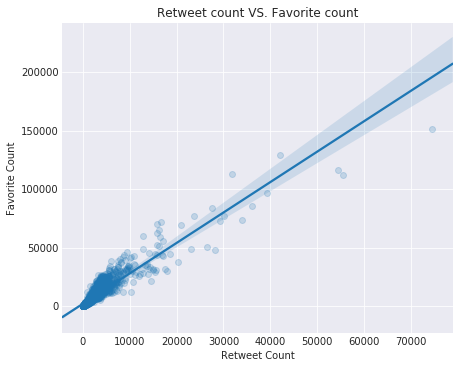

In [78]:
sns.lmplot(x="retweet_count", 
           y="favorite_count", 
           data= wrangling_df,
           size = 5,
           aspect=1.3,
           scatter_kws={'alpha':1/5});
plt.title('Retweet count VS. Favorite count')
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');

*Insights* :
 There is a linear relationship between Favorite count and Retweet count.
 It's a positive correlation

- The most popular dog names 

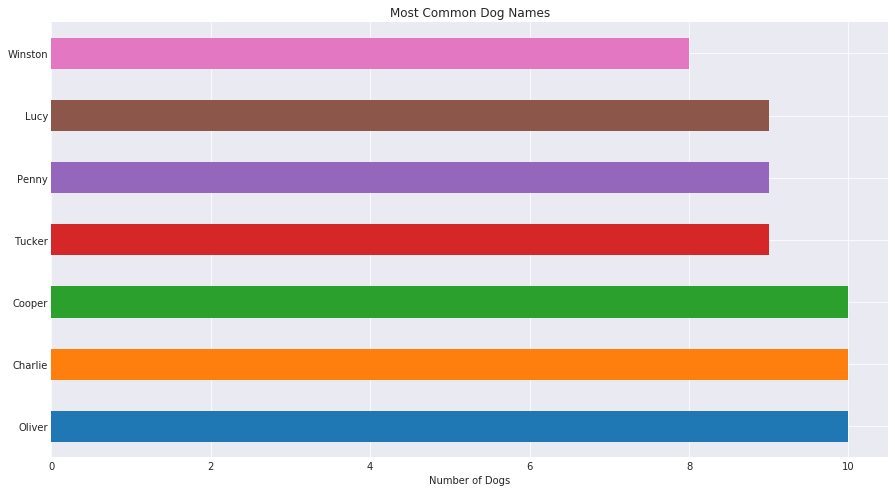

In [79]:
wrangling_df.name.value_counts()[0:7].plot('barh', figsize=(15,8), title='Most Common Dog Names').set_xlabel("Number of Dogs");

In [80]:
wrangling_df.name.value_counts()

Oliver       10
Charlie      10
Cooper       10
Tucker        9
Penny         9
Lucy          9
Winston       8
Sadie         8
Lola          7
Toby          7
Daisy         7
Koda          6
Bella         6
Stanley       6
Bo            6
Jax           6
Oscar         5
Scout         5
Buddy         5
Milo          5
Rusty         5
Dave          5
Bailey        5
Louis         5
Chester       5
Leo           5
Jack          4
Oakley        4
Maggie        4
Dexter        4
             ..
Eriq          1
Major         1
Jackie        1
Creg          1
Olaf          1
Josep         1
Tonks         1
Pluto         1
Dwight        1
Keurig        1
Venti         1
Meera         1
Willie        1
Maude         1
Brandi        1
Genevieve     1
Jockson       1
Bode          1
Kane          1
Ken           1
Covach        1
Snoop         1
Arya          1
Yoda          1
Arnie         1
Ulysses       1
Gustav        1
Timofy        1
Bowie         1
Timison       1
Name: name, Length: 908,

*Insights* : The most three popular dog names are Cooper, Oliver, Charlie and Lucy.

- Percentage of different dog stages

In [81]:
stages = wrangling_df.dog_stage.value_counts()
stages

None             1645
pupper            201
doggo              62
puppo              22
doggo,pupper        8
floofer             7
doggo,floofer       1
doggo,puppo         1
Name: dog_stage, dtype: int64

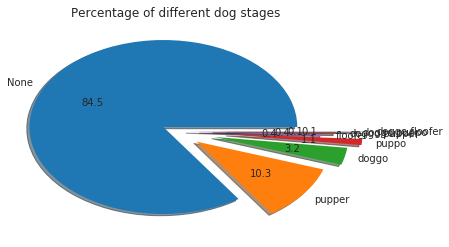

In [82]:
plt.pie(stages, labels=[ 'None','pupper', 'doggo', 'puppo', 'floofer', 'doggo,pupper', 'doggo,puppo', 'doggo,floofer'], autopct = '%1.1f', shadow=True, explode=(0.1, 0.2, 0.3, 0.4, 0.1, 0.2, 0.3, 0.4))
plt.title('Percentage of different dog stages');     

*Insights* : Most dogs don't have stage and from the dogs that have stage, *Pupper* has the highst percentage and *Floofer* has the lowest percentage

- Total number of tweets over time to see does it increase or decrease.

In [83]:
wrangling_df.timestamp = pd.to_datetime(wrangling_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
monthly_tweets = wrangling_df.groupby(pd.Grouper(key = 'timestamp', freq = "M")).count().reset_index()
monthly_tweets = monthly_tweets[['timestamp', 'tweet_id']]
monthly_tweets.head()
monthly_tweets.sum()

tweet_id    1947
dtype: int64

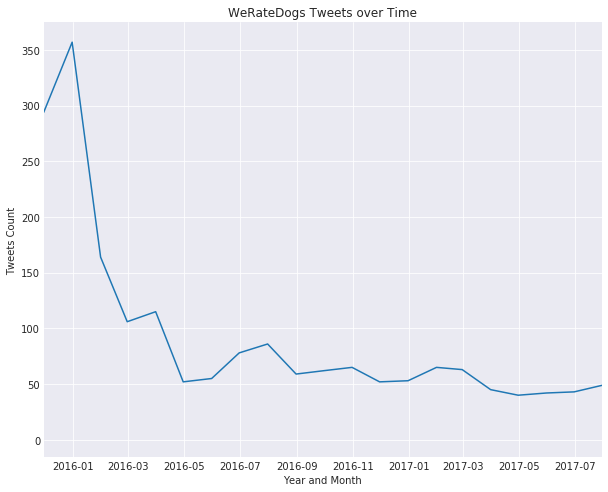

In [84]:
plt.figure(figsize=(10, 8))
plt.xlim([datetime.date(2015, 11, 30), datetime.date(2017, 7, 30)]) 

plt.xlabel('Year and Month')
plt.ylabel('Tweets Count')

plt.plot(monthly_tweets.timestamp, monthly_tweets.tweet_id)
plt.title('WeRateDogs Tweets over Time');

*Insights* : Over time tweets decreased sharply, with spikes in activity during the early spring of 2016, mid-summer of 2016, and generally decreasing from there.